In [1]:
import pandas as pd
import numpy as np
import time, os, ast

pd.options.display.max_columns = 50

In [2]:
TOTAL_DAYS = 400
START_POI = 0
END_POI = 400

In [3]:
class bounding_box:
    def __init__(self, _lat_min, _lon_min, _lat_max, _lon_max):
        self.lat_min = _lat_min
        self.lon_min = _lon_min
        self.lat_max = _lat_max
        self.lon_max = _lon_max


class stat_collector:
    def __init__(self):
        self.parquet_file_count=0
        self.data_record_count = 0
        self.memory_usage_in_GB = 0		#gives an estimate of the total RAM usage if all files were read into memory at the same time.
        self.unique_device_count = 0
        self.avg_pos_acc = 0
        self.starting_time = time.process_time()
        self.elapsed_time = time.process_time()
        self.unique_geohash_count = 0

def get_merged_df(csv_path, start_row, end_row, total_days):

    #start = time.time()
    merge_df = pd.read_csv(csv_path)

    merge_df = merge_df.sort_values(by=['raw_visit_counts'], ascending=False)
    merge_df = merge_df.iloc[start_row:end_row]
    #print(merge_df)
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: x[:total_days*24])
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: x[:total_days])
    return merge_df


def load_poi_db(city):
    poi_folder = "/storage/dataset/poi_haowen/CoreRecords-CORE_POI-2019_03-2020-03-25/"
    poi_columns = ["safegraph_place_id", "parent_safegraph_place_id", "location_name", "safegraph_brand_ids", "brands",
                   "top_category", "sub_category", "naics_code", "latitude", "longitude", "street_address", "city",
                   "region", "postal_code", "iso_country_code", "phone_number", "open_hours", "category_tags"]
    files = os.listdir(poi_folder)


    poi_s = stat_collector()
    poi_db = pd.DataFrame(columns=poi_columns)
    for f in files:
        if f[-3:] == 'csv' and 'brand' not in f:
            print(f)
            df = pd.read_csv(poi_folder + f)
            df = df.loc[df['city']==city]
            poi_db = poi_db.append(df, ignore_index=True, sort=False)
            poi_s.memory_usage_in_GB += df.memory_usage(deep=True).sum() / 1000000000
            poi_s.data_record_count += df.shape[0]
            poi_s.parquet_file_count += 1
    return poi_db, poi_s


def get_full_df(csv_path_weekly, poi_info_csv_path, start_row, end_row, total_days, city):
    weekly_patterns = get_merged_df(csv_path_weekly, start_row, end_row, total_days)
    poi_info = pd.read_csv(poi_info_csv_path)
    poi_df = pd.merge(weekly_patterns, poi_info, on='safegraph_place_id', how='inner')
    poi_db, poi_s = load_poi_db(city=city)
    poi_df = poi_df.merge(poi_db, how='left', on='safegraph_place_id', suffixes=('', '_y'))
    poi_df.drop(poi_df.filter(regex='_y$').columns, axis=1, inplace=True)
    del poi_db
    return poi_df

### Houston Dataset Stats

In [4]:
DATASET = 'Houston'
csv_path = f'/home/users/arash/datasets/safegraph/weekly_patterns_2019-01-07_2020-06-08_{DATASET}.csv'
poi_info_csv_path = '/home/users/arash/datasets/safegraph/core_poi_info_2019-01-07_2020-06-08.csv'

houston_df = get_full_df(csv_path_weekly=csv_path, 
                         poi_info_csv_path=poi_info_csv_path, 
                         start_row=START_POI, end_row=END_POI, 
                         total_days=TOTAL_DAYS,
                         city=DATASET)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


In [5]:
houston_df.head(2)

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6140, 6399, 6752, 7324, 7255, 5874, 7496, 700...","[83, 49, 41, 60, 187, 301, 161, 151, 257, 112,...",3574654,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.981382,-95.322839,NaN,NaN,NaN
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2553, 2568, 2729, 2939, 2940, 2541, 3215, 290...","[21, 23, 21, 14, 52, 108, 53, 56, 130, 38, 119...",1427339,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN,sg:f4a955def8ca49fd87153af82a237245,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,29.987829,-95.334916,NaN,"{ ""Mon"": [[""5:30"", ""21:00""]], ""Tue"": [[""5:30"",...",NaN


In [6]:
print('Number of POI categories:')
len(houston_df['top_category'].unique())

Number of POI categories:


43

In [7]:
print('Median number of hourly POI visits:')
houston_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


11.40153203125

In [8]:
red_houston_df = houston_df.iloc[:40]
red_houston_df.shape

(40, 21)

In [10]:
print('Number of POI categories:')
len(red_houston_df['top_category'].unique())

Number of POI categories:


12

In [12]:
print('Median number of hourly POI visits:')
red_houston_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


47.81776041666666

### Chicago Dataset Stats

In [14]:
DATASET = 'Chicago'
csv_path = f'/home/users/arash/datasets/safegraph/weekly_patterns_2019-01-07_2020-06-08_{DATASET}.csv'
poi_info_csv_path = '/home/users/arash/datasets/safegraph/core_poi_info_2019-01-07_2020-06-08.csv'

chicago_df = get_full_df(csv_path_weekly=csv_path, 
                         poi_info_csv_path=poi_info_csv_path, 
                         start_row=START_POI, end_row=END_POI, 
                         total_days=TOTAL_DAYS,
                         city=DATASET)

chicago_df.head(2)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:87441fbb4b6a4d7aaec3ed7eb83a72de,"[1693, 1837, 1852, 2022, 2066, 1753, 2195, 202...","[23, 9, 12, 16, 53, 81, 68, 51, 73, 70, 64, 52...",1103171,Chicago O'Hare International Airport Terminal 1,10000 W Ohare Ave,Chicago,IL,60666,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,41.979266,-87.909937,NaN,NaN,NaN
1,sg:dc60abeb131940e79e8dbf7895dc2770,"[1171, 1181, 1315, 1294, 1286, 1067, 1604, 130...","[21, 5, 4, 10, 32, 60, 19, 42, 22, 25, 29, 45,...",771330,Big City Chicken,5700 S Cicero Ave Concourse B Gate B7 Midway A...,Chicago,IL,60629,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print('Number of POI categories:')
len(chicago_df['top_category'].unique())

Number of POI categories:


35

In [16]:
print('Median number of hourly POI visits:')
chicago_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


6.215655208333333

In [17]:
red_chicago_df = chicago_df.iloc[:40]
red_chicago_df.shape

(40, 21)

In [18]:
print('Number of POI categories:')
len(red_chicago_df['top_category'].unique())

Number of POI categories:


14

In [19]:
print('Median number of hourly POI visits:')
red_chicago_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


21.987221354166667

### Los Angeles Dataset Stats

In [20]:
DATASET = 'Los Angeles'
csv_path = f'/home/users/arash/datasets/safegraph/weekly_patterns_2019-01-07_2020-06-08_{DATASET}.csv'
poi_info_csv_path = '/home/users/arash/datasets/safegraph/core_poi_info_2019-01-07_2020-06-08.csv'

la_df = get_full_df(csv_path_weekly=csv_path, 
                         poi_info_csv_path=poi_info_csv_path, 
                         start_row=START_POI, end_row=END_POI, 
                         total_days=TOTAL_DAYS,
                         city=DATASET)

la_df.head(2)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:eec9c174dc034b72b18e95737c6a98dc,"[2346, 2475, 2491, 2589, 2691, 2513, 2851, 260...","[61, 17, 19, 17, 33, 32, 49, 63, 73, 63, 72, 2...",1231628,Farmer's Market,Lax Terminal 4,Los Angeles,CA,90045,US,NaN,NaN,sg:08dfccb58e4c4478a4578254593913d3,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,33.940858,-118.404222,NaN,NaN,NaN
1,sg:0d9a31b3a55c4df08da3c8ce5a8deb0e,"[869, 1047, 1072, 1153, 1112, 937, 1227, 1027,...","[24, 6, 4, 11, 11, 9, 17, 10, 14, 21, 23, 103,...",586540,American Eagle Remote Terminal,World Way,Los Angeles,CA,90045,US,NaN,NaN,sg:08dfccb58e4c4478a4578254593913d3,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110.0,33.943828,-118.400097,NaN,NaN,NaN


In [21]:
print('Number of POI categories:')
len(la_df['top_category'].unique())

Number of POI categories:


44

In [22]:
print('Median number of hourly POI visits:')
la_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


5.769618489583333

In [23]:
red_la_df = la_df.iloc[:40]
red_la_df.shape

(40, 21)

In [24]:
print('Number of POI categories:')
len(red_la_df['top_category'].unique())

Number of POI categories:


14

In [25]:
print('Median number of hourly POI visits:')
red_la_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


22.7842890625

### New York Dataset Stats

In [26]:
DATASET = 'New York'
csv_path = f'/home/users/arash/datasets/safegraph/weekly_patterns_2019-01-07_2020-06-08_{DATASET}.csv'
poi_info_csv_path = '/home/users/arash/datasets/safegraph/core_poi_info_2019-01-07_2020-06-08.csv'

ny_df = get_full_df(csv_path_weekly=csv_path, 
                         poi_info_csv_path=poi_info_csv_path, 
                         start_row=START_POI, end_row=END_POI, 
                         total_days=TOTAL_DAYS,
                         city=DATASET)

ny_df.head(2)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:50411cf6c22142b6ae91d0eaa2e3190c,"[9596, 10273, 10984, 11750, 11310, 10363, 1160...","[244, 120, 143, 180, 283, 569, 533, 281, 183, ...",5130262,John F Kennedy International Airport,John F. Kennedy International Airport,New York,NY,11430,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,40.639210,-73.774480,NaN,NaN,NaN
1,sg:354dce54a24840899c681d5e62d52899,"[1616, 1656, 1708, 1869, 1790, 1818, 1949, 183...","[36, 11, 23, 59, 78, 116, 102, 48, 46, 35, 23,...",908759,John F Kennedy International Airport Terminal 5,John F. Kennedy International Airport Terminal 5,New York,NY,11430,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,40.646035,-73.776445,NaN,NaN,NaN


In [27]:
print('Number of POI categories:')
len(ny_df['top_category'].unique())

Number of POI categories:


32

In [28]:
print('Median number of hourly POI visits:')
ny_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


8.881783333333333

In [29]:
red_ny_df = ny_df.iloc[:40]
red_ny_df.shape

(40, 21)

In [30]:
print('Number of POI categories:')
len(red_ny_df['top_category'].unique())

Number of POI categories:


10

In [31]:
print('Median number of hourly POI visits:')
red_ny_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


36.173609375

### San Antonio Dataset Stats

In [32]:
DATASET = 'San Antonio'
csv_path = f'/home/users/arash/datasets/safegraph/weekly_patterns_2019-01-07_2020-06-08_{DATASET}.csv'
poi_info_csv_path = '/home/users/arash/datasets/safegraph/core_poi_info_2019-01-07_2020-06-08.csv'

sa_df = get_full_df(csv_path_weekly=csv_path, 
                         poi_info_csv_path=poi_info_csv_path, 
                         start_row=START_POI, end_row=END_POI, 
                         total_days=TOTAL_DAYS,
                         city=DATASET)

sa_df.head(2)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:6e92f4bf113945ce9523ac1de6f0eec9,"[1728, 2001, 2028, 2245, 2145, 1471, 2011, 210...","[47, 9, 10, 39, 111, 92, 63, 52, 43, 40, 50, 5...",1072682,San Antonio International Airport,9800 Airport Blvd,San Antonio,TX,78216,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.531062,-98.469002,1.210207e+10,NaN,NaN
1,sg:0a02d0db794a4a99bc508a079afecfec,"[1108, 1208, 1299, 1333, 1903, 2793, 1996, 106...","[5, 2, 1, 1, 1, 3, 3, 7, 3, 11, 21, 42, 58, 16...",901514,Rim Shopping Center The,17503 La Cantera Pkwy,San Antonio,TX,78257,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,29.609904,-98.597926,NaN,NaN,NaN


In [33]:
print('Number of POI categories:')
len(sa_df['top_category'].unique())

Number of POI categories:


42

In [34]:
print('Median number of hourly POI visits:')
sa_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


8.127254687499999

In [35]:
red_sa_df = sa_df.iloc[:40]
red_sa_df.shape

(40, 21)

In [36]:
print('Number of POI categories:')
len(red_sa_df['top_category'].unique())

Number of POI categories:


12

In [37]:
print('Median number of hourly POI visits:')
red_sa_df['visits_by_each_hour'].apply(lambda x: np.array(x).mean()).mean()

Median number of hourly POI visits:


28.353481770833334

### Pair-wise temporal correlations

In [1]:
x_axis = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x_label = 'Day of the Week'
y_label = 'Correlation Score'
legends = ['LA Coliseum - Starbucks Temporal Visits Correlations',
            'LA Coliseum - Korean BBQ Temporal Visits Correlations',
            'Starbucks - Korean BBQ Temporal Visits Correlations']
star_kor_corr = [0.5, 0.56, 0.49, 0.6, 0.61, 0.62, 0.70]
lacol_star_corr = [0.2, 0.24, 0.19, 0.31, 0.45, 0.90, 0.55]
lacol_kor_corr = [0.16, 0.12, 0.17, 0.20, 0.23, 0.57, 0.47]

In [2]:
import matplotlib.pyplot as plt

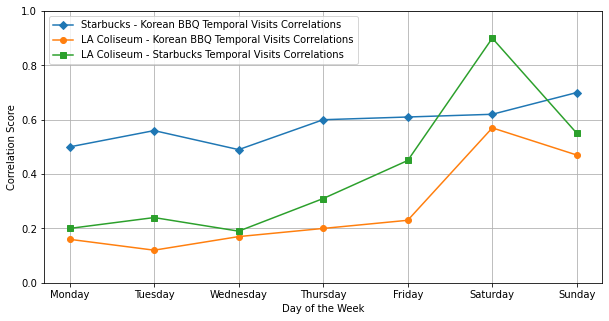

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_axis, star_kor_corr, '-D', label=legends[2])
ax.plot(x_axis, lacol_kor_corr, '-o', label=legends[1])
ax.plot(x_axis, lacol_star_corr, '-s', label=legends[0])
ax.set_ylim(0, 1)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
ax.legend()
ax.grid()
plt.savefig('temp_corrs.png', transparent=True)